In [1]:
import cv2
import numpy as np
import os 
import dicom
import data
import copy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from scipy import ndimage
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects
from scipy import ndimage
from sklearn import metrics,metrics
from scipy.ndimage.measurements import label
%matplotlib inline

Using TensorFlow backend.


In [2]:
nb_classes = 2
RECEP_HEI = 56
RECEP_WEI = 28
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=( 1 , RECEP_HEI, RECEP_WEI)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.load_weights('weights.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#model.fit(X_train, Y_train, batch_size=32, nb_epoch=1,
          #verbose=1, shuffle = True ,validation_split=0.25)

In [3]:
def get_input_and_output(source):
    file = open(source, 'r')
    list = file.readlines()
    test_array = np.empty((0,len(list)), int)
    for line in list:
        #print line
        line = line.split(',')
        line[len(line)-1] = line[len(line)-1].replace('\n','')
        line = map(int, line)
        test_array = np.append(test_array,np.array([line]),axis = 0)
    dir_array = source.split('/')
    dir_name = dir_array[len(dir_array)-1].split('_')
    dir_image_file = DATA_PATH+'/data/Sagittal-segmentation/'+dir_name[0]+'/'+dir_name[1]+'/'+str(dir_name[2]).replace('txt','dcm')
    medical_img=dicom.read_file(dir_image_file)
    return medical_img.pixel_array , test_array

In [4]:
    MODE_TEST_PATH = '/data/metROI/test2_txt'
    DATA_PATH =  os.getcwd()
    IMG_COLS = 320
    IMG_ROWS = 320
    count_img = 0
    count = 0
    index = 0
    count_pos = 0
    class_lable = 2
    x_start = RECEP_WEI 
    y_start = RECEP_HEI 
    y_max = IMG_COLS
    x_max = IMG_ROWS/2
    MODE = 'test'
    if MODE == 'train':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TRAIN_PATH
    elif MODE == 'test':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TEST_PATH
    IMG_LIST = os.listdir(TRAIN_DATA_TXT_PATH)
    TRAIN_NUM = len(IMG_LIST)
    #TRAIN_IN = np.ndarray((TRAIN_NUM * 38544, 1, RECEP_WEI, RECEP_HEI), dtype=np.float32)
    #TRAIN_OUT = np.ndarray((TRAIN_NUM * 38544, 2), dtype=np.float32)
    TRAIN_OUT = []
    TRAIN_IN = []
    for name in IMG_LIST:
            med_img , test_array = get_input_and_output(TRAIN_DATA_TXT_PATH + '/' + name)
            test_array = test_array + 0.01
            med_img = cv2.resize(med_img, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)
            test_array = cv2.resize(test_array, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)

    
            cropImg1 = med_img[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]
            cropImg2 = test_array[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]


            for i in range(y_start, y_max):
                for m in range(x_start, x_max):
                    region = cropImg1[i- RECEP_HEI: i, m- RECEP_WEI: m]
                    class_lable = cropImg2[i- RECEP_HEI/2][m- RECEP_WEI/2]
                    if(class_lable != 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([0], nb_classes)[0])
                        index += 1
                        #print(index)
                        
                    elif (class_lable == 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([1], nb_classes)[0])
                        count_pos += 1
                        index += 1
                        #print(index)
                        
                    count += 1
            if(index%1000 == 0):
                    print('Processed training set:'+str(index))

            count_img += 1
            print('Processed images:'+str(count_img)+'.Positive num:'+str(count_pos)+'.Total size:'+str(index))
    TRAIN_IN = np.asarray(TRAIN_IN, dtype=np.float)
    TRAIN_OUT = np.asarray(TRAIN_OUT, dtype=np.float)

Processed images:1.Positive num:943.Total size:34848


In [16]:
print('Normalizing training data...')
for i in range(TRAIN_IN.shape[0]):
    for m in range(TRAIN_IN.shape[1]):
        mean = np.mean(TRAIN_IN[i][m])  # mean for data centering
        std = np.std(TRAIN_IN[i][m])  # std for data normalization
        TRAIN_IN[i][m] = (TRAIN_IN[i][m] - mean)/std

Normalizing training data...


In [17]:
predict_result = model.predict_classes(TRAIN_IN)

34848/34848 [==============================] - 368s   


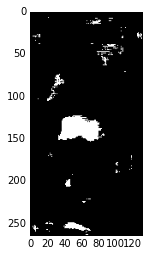

In [58]:
plt.imshow(a[3].reshape(y_max - y_start,x_max - x_start),'gray')

In [9]:
load = np.load('predicted_image.npy')
load1 = np.load('answer_image.npy')
load1 = np.argmax(load1, axis=1)

In [10]:
a = []
for i in range(0, len(load), (y_max - y_start) * (x_max - x_start)):
    tmp = load[i:i+(y_max - y_start) * (x_max - x_start)]
    tmp = tmp.reshape(y_max - y_start,x_max - x_start)
    #kernel = np.ones((4.5,4.5),np.uint8)
    #tmp = cv2.erode(tmp,kernel,iterations = 1)
    a.append(tmp)

In [11]:
d = []
for i in range(0, len(load1), (y_max - y_start) * (x_max - x_start)):
    tmp = load1[i:i+(y_max - y_start) * (x_max - x_start)]
    tmp = tmp.reshape(y_max - y_start,x_max - x_start)
    #kernel = np.ones((4.5,4.5),np.uint8)
    #tmp = cv2.erode(tmp,kernel,iterations = 1)
    d.append(tmp)
d = np.asarray(d)

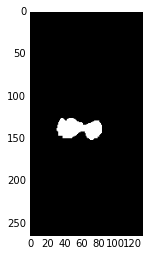

In [57]:
plt.imshow(d[3],'gray')

In [99]:
for i in range(predict.shape[0]):
    #im = ndimage.grey_erosion(predict[i], size=(3.0,3.0))
    confusion_matrix = ConfusionMatrix(answer[i].reshape(264*132), predict[i].reshape(264*132))
    print(i,confusion_matrix.classification_report.precision[1],confusion_matrix.classification_report.recall[1],confusion_matrix.classification_report.F1_score[1])

(0, 0.50124223602484475, 0.88583973655323822, 0.64022213407378026)
(1, 0.5702247191011236, 0.86108165429480377, 0.6861005492184199)
(2, 0.45005549389567145, 0.83094262295081966, 0.58387329013678901)
(3, 0.45913734392735528, 0.85972369819341121, 0.59859415464298926)
(4, 0.33831940167179936, 0.8367791077257889, 0.48182957393483711)
(5, 0.28857715430861725, 0.84705882352941175, 0.43049327354260092)
(6, 0.0, 0.0, 0.0)
(7, 0.0, 0.0, 0.0)
(8, 0.0015552099533437014, 0.090909090909090912, 0.0030581039755351682)
(9, 0.10843373493975904, 0.27457627118644068, 0.15547024952015356)
(10, 0.092995169082125601, 0.27208480565371024, 0.13861386138613863)
(11, 0.092447916666666671, 0.30869565217391304, 0.14228456913827656)
(12, 0.036160420775805391, 0.21484375, 0.061902082160945414)
(13, 0.081385979049153914, 0.33666666666666667, 0.13108371187540557)
(14, 0.18421052631578946, 0.33946488294314381, 0.23882352941176471)
(15, 0.23366013071895425, 0.55533980582524267, 0.32892466935020126)
(16, 0.2258265751715

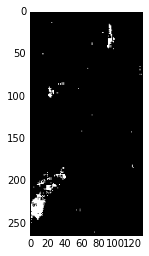

In [100]:
plt.imshow(a[6],'gray')

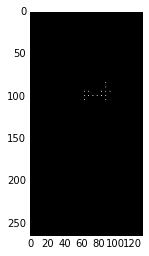

In [101]:
plt.imshow(d[6],'gray')

In [4]:
    MODE_TEST_PATH = '/data/metROI/test_txt'
    DATA_PATH =  os.getcwd()
    IMG_COLS = 320
    IMG_ROWS = 320
    count_img = 0
    count = 0
    index = 0
    count_pos = 0
    class_lable = 2
    x_start = RECEP_WEI 
    y_start = RECEP_HEI 
    y_max = IMG_COLS
    x_max = IMG_ROWS/2
    MODE = 'test'
    if MODE == 'train':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TRAIN_PATH
    elif MODE == 'test':
        TRAIN_DATA_TXT_PATH = DATA_PATH + MODE_TEST_PATH
    IMG_LIST = os.listdir(TRAIN_DATA_TXT_PATH)
    TRAIN_NUM = len(IMG_LIST)
    #TRAIN_IN = np.ndarray((TRAIN_NUM * 38544, 1, RECEP_WEI, RECEP_HEI), dtype=np.float32)
    #TRAIN_OUT = np.ndarray((TRAIN_NUM * 38544, 2), dtype=np.float32)
    SOURCE_IMAGE = []
    SOURCE_RESULT = []
    TRAIN_OUT = []
    TRAIN_IN = []
    for name in IMG_LIST:
            med_img , test_array = get_input_and_output(TRAIN_DATA_TXT_PATH + '/' + name)
            SOURCE_IMAGE.append(med_img)
            SOURCE_RESULT.append(test_array)
            test_array = test_array + 0.01
            med_img = cv2.resize(med_img, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)
            test_array = cv2.resize(test_array, (IMG_ROWS,IMG_COLS), interpolation = cv2.INTER_AREA)

    
            cropImg1 = med_img[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]
            cropImg2 = test_array[0:IMG_ROWS, IMG_COLS/4 : 3*IMG_ROWS/4 ]


            for i in range(y_start, y_max):
                for m in range(x_start, x_max):
                    region = cropImg1[i- RECEP_HEI: i, m- RECEP_WEI: m]
                    class_lable = cropImg2[i- RECEP_HEI/2][m- RECEP_WEI/2]
                    if(class_lable != 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([0], nb_classes)[0])
                        index += 1
                        #print(index)
                        
                    elif (class_lable == 1.01):
                        TRAIN_IN.append(region.reshape(1,RECEP_HEI, RECEP_WEI))
                        TRAIN_OUT.append(np_utils.to_categorical([1], nb_classes)[0])
                        count_pos += 1
                        index += 1
                        #print(index)
                        
                    count += 1
            if(index%1000 == 0):
                    print('Processed training set:'+str(index))

            count_img += 1
            print('Processed images:'+str(count_img)+'.Positive num:'+str(count_pos)+'.Total size:'+str(index))
    TRAIN_IN = np.asarray(TRAIN_IN, dtype=np.float)
    TRAIN_OUT = np.asarray(TRAIN_OUT, dtype=np.float)

Processed images:1.Positive num:911.Total size:34848
Processed images:2.Positive num:1854.Total size:69696
Processed images:3.Positive num:2830.Total size:104544
Processed images:4.Positive num:3771.Total size:139392
Processed images:5.Positive num:4690.Total size:174240
Processed images:6.Positive num:5540.Total size:209088
Processed images:7.Positive num:5555.Total size:243936
Processed images:8.Positive num:5567.Total size:278784
Processed images:9.Positive num:5578.Total size:313632
Processed images:10.Positive num:5873.Total size:348480
Processed images:11.Positive num:6156.Total size:383328
Processed images:12.Positive num:6386.Total size:418176
Processed images:13.Positive num:6642.Total size:453024
Processed images:14.Positive num:6942.Total size:487872
Processed images:15.Positive num:7540.Total size:522720
Processed images:16.Positive num:8055.Total size:557568
Processed images:17.Positive num:8546.Total size:592416
Processed images:18.Positive num:9023.Total size:627264
Proc

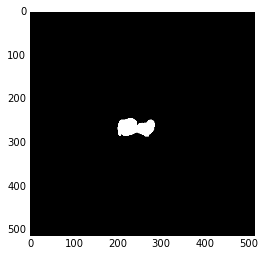

In [65]:
plt.imshow(SOURCE_RESULT[2],'gray')

In [84]:
predict = np.load('predicted_image.npy')
predict = predict.reshape((22,264,132))
answer1 = np.load('answer_image.npy')
answer = np_utils.categorical_probas_to_classes(answer1)
answer = answer.reshape((22,264,132))

In [235]:
i = 2

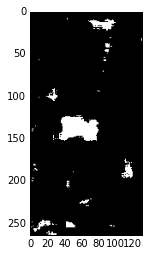

In [243]:
plt.imshow(predict[i],'gray')

In [255]:
predict2 = transfer_prob(predict[i].reshape(264*132), 0.1)
class_lable = predict2.astype(bool).reshape(264,132)
predict2 = remove_small_objects(class_lable, 256,in_place=False)

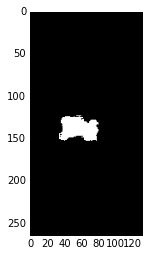

In [256]:
plt.imshow(predict2,'gray')

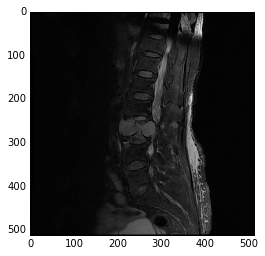

In [239]:
plt.imshow(SOURCE_IMAGE[i],'gray')

In [14]:
def get_FROC(i):
    prob1 = np.load('result_prob.npy')
    prob = prob1[0:prob1.shape[0],1]
    prob = prob.reshape((22,264, 132 ))
    y = answer[i].reshape(answer.shape[1]*answer.shape[2])
    scores = prob[i].reshape(prob.shape[1]*prob.shape[2])
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

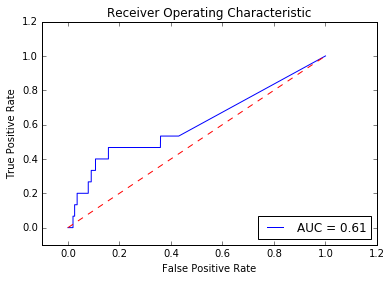

In [15]:
get_FROC(6)

In [16]:
plt.imshow(tm1,'gray')

NameError: name 'tm1' is not defined

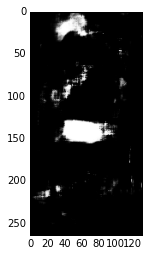

In [119]:
plt.imshow(prob[5],'gray')

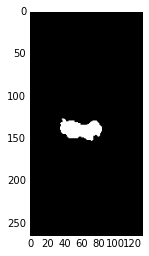

In [124]:
plt.imshow(answer[5],'gray')

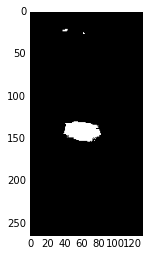

In [147]:
plt.imshow(tm1,'gray')

In [17]:
    
    
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

IndentationError: expected an indented block (<ipython-input-17-02632999ec9b>, line 4)

In [14]:
y_score = np.load('result_prob.npy')
predict_class = np.load('predicted_image.npy')
y_true = np.load('answer_image.npy')

y_score = y_score[0:y_score.shape[0],1]
y_score = y_score.reshape(22,34848)
y_true = y_true[0:y_true.shape[0],1]
y_true = y_true.reshape(22,34848)
predict_class = predict_class.reshape(22,34848)

set_size = 22
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true.reshape(y_true.shape[0]*y_true.shape[1]), y_score.reshape(y_score.shape[0]*y_score.shape[1]))


In [85]:
for t in range(1, thresholds.size):
    TPR_list = []
    FP_num_list = []
    tpr_sum = 0
    fp_sum = 0
    for i in range(set_size):
        TPR, FP_num = getPara(y_score[i], y_true[i], predict_class[i], t)
        tpr_sum += TPR
        fp_sum += fp_sum
    print(t,thresholds.size)
    TPR_list.append(tpr_sum/np.float(set_size))
    FP_num_list.append(fp_sum/np.float(set_size))

(1, 35123)
(2, 35123)
(3, 35123)
(4, 35123)
(5, 35123)
(6, 35123)
(7, 35123)
(8, 35123)
(9, 35123)
(10, 35123)
(11, 35123)
(12, 35123)
(13, 35123)
(14, 35123)


KeyboardInterrupt: 

In [2]:
def getPara(predict, true, threshold):
    (TP, FP, TN, FN, class_lable) = perf_measure(true, predict, threshold)
    if((TP + FN)== 0):
        TPR = 0
    else:
        TPR = np.float(TP)/(TP + FN)
    
    class_lable = class_lable.astype(bool).reshape(264,132)
    true = predict.astype(bool).reshape(264,132)
    
    predict2 = remove_small_objects(class_lable, 64,in_place=False)
    true2 = remove_small_objects(true, 64,in_place=False)
    labeled_array1, num_features1 = label(predict2)
    labeled_array2, num_features2 = label(true2)
    FP_num = num_features1 - num_features2
    return TPR, FP_num

In [3]:
def perf_measure(y_actual, predict, threshold):
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    predict = transfer_prob(predict, threshold)
    for i in range(len(predict)): 
        if y_actual[i]==predict[i]==1:
           TP += 1
    for i in range(len(predict)): 
        if y_actual[i]==1 and y_actual[i]!=predict[i]:
           FP += 1
    for i in range(len(predict)): 
        if y_actual[i]==predict[i]==0:
           TN += 1
    for i in range(len(predict)): 
        if y_actual[i]==0 and y_actual[i]!=predict[i]:
           FN += 1

    return(TP, FP, TN, FN, predict)

In [4]:
def transfer_prob(y_score, threshold):
    y_result = []
    for i in range(len(y_score)):
        if y_score[i] >= threshold:
            y_result.append(1)
        else:
            y_result.append(0)
    return np.asarray(y_result)

In [10]:
TPR_list = np.load('TPR_list.npy') 
FP_num_list = np.load('FP_num_list.npy')

TPR_list1= np.load('TPR_list_pure_good.npy') 
FP_num_list1 = np.load('FP_num_list_pure_good.npy')

TPR_list2= np.load('TPR_list1.npy') 
FP_num_list2 = np.load('FP_num_list1.npy')

false_positive_rate, true_positive_rate, threshol = metrics.roc_curve(y_true.reshape(y_true.shape[0]*y_true.shape[1]), y_score.reshape(y_score.shape[0]*y_score.shape[1]))
thresholds = []
count = 1
for i in range(threshol.shape[0]):
    if(threshol[i] > 0.01 and count%100 == 0):
        thresholds.append(threshol[i])
    count += 1
thresholds = np.asarray(thresholds)

/Users/fangzhiyuan/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/fangzhiyuan/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


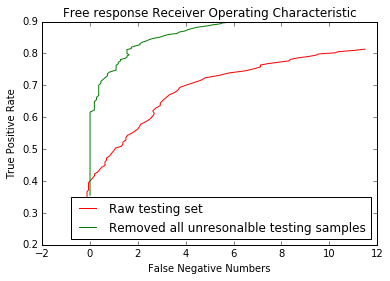

In [11]:
    plt.gca().set_color_cycle(['red', 'green', 'blue'])
    plt.title('Free response Receiver Operating Characteristic')
    plt.plot((FP_num_list), (TPR_list))
    plt.plot((FP_num_list1), (TPR_list1))
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Negative Numbers')
    plt.legend(['Raw testing set', 'Removed all unresonalble testing samples', 'Raw testing samples'], loc='lower right')
    plt.show()

In [12]:
TPR_list1= np.load('TPR_list1.npy') 
FP_num_list1 = np.load('FP_num_list1.npy')

In [29]:
    (TP, FP, TN, FN, class_lable) = perf_measure(y_true[1], y_score[1], 0.9)

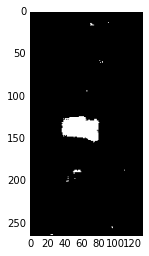

In [30]:
plt.imshow(class_lable.reshape(264,132),'gray')

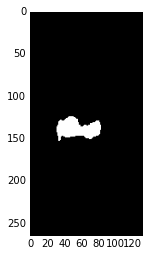

In [34]:
plt.imshow(y_true[1].reshape(264,132),'gray')

In [35]:
    class_lable = class_lable.astype(bool).reshape(264,132)
    true = y_true[1].astype(bool).reshape(264,132)
    
    predict2 = remove_small_objects(class_lable, 64,in_place=False)
    labeled_array1, num_features1 = label(predict2)
    labeled_array2, num_features2 = label(true)
    num_features1 - num_features2

In [39]:
num_features1

1

In [27]:
    (TP, FP, TN, FN, class_lable3) = perf_measure(y_true[1], y_score[1], 0.1)

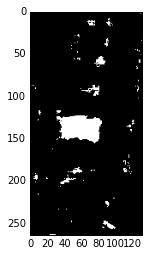

In [28]:
plt.imshow(class_lable3.reshape(264,132),'gray')

In [53]:
    class_lable3 = class_lable3.astype(bool).reshape(264,132)
    true = y_true[1].astype(bool).reshape(264,132)
    
    predict2 = remove_small_objects(class_lable3, 64,in_place=False)
    labeled_array1, num_features1 = label(predict2)
    labeled_array2, num_features2 = label(true)
    num_features1 - num_features2

2

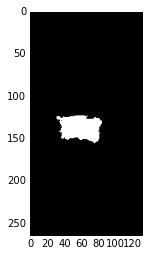

In [51]:
plt.imshow(predict2.reshape(264,132),'gray')

In [15]:


TPR_list1= np.load('TPR_list_pure_good.npy') 
FP_num_list1 = np.load('FP_num_list_pure_good.npy')

#TPR_list2= np.load('TPR_list1.npy') 
#FP_num_list2 = np.load('FP_num_list1.npy')

false_positive_rate, true_positive_rate, threshol = metrics.roc_curve(y_true.reshape(y_true.shape[0]*y_true.shape[1]), y_score.reshape(y_score.shape[0]*y_score.shape[1]))
thresholds = []
count = 1
for i in range(threshol.shape[0]):
    if(threshol[i] > 0.01 and count%100 == 0):
        thresholds.append(threshol[i])
    count += 1
thresholds = np.asarray(thresholds)

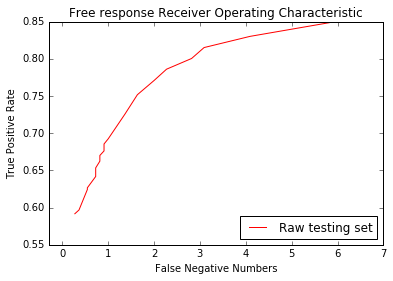

In [16]:
    plt.gca().set_color_cycle(['red', 'green', 'blue'])
    plt.title('Free response Receiver Operating Characteristic')
    #plt.plot((FP_num_list), (TPR_list))
    plt.plot((FP_num_list1), (TPR_list1))
    plt.xlim([-0.3,7])
    plt.legend(loc='lower right')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Negative Numbers')
    plt.legend(['Raw testing set', 'Removed all unresonalble testing samples', 'Raw testing samples'], loc='lower right')
    plt.show()

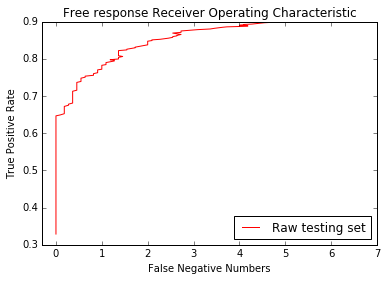

In [111]:
# size = 160

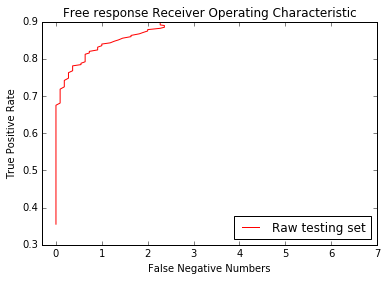

In [101]:
# size = 256

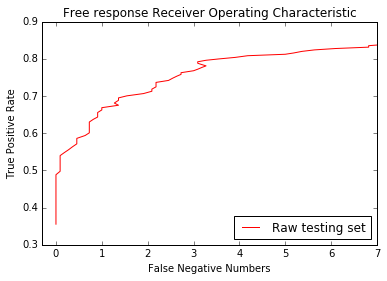

In [97]:
# size = 40

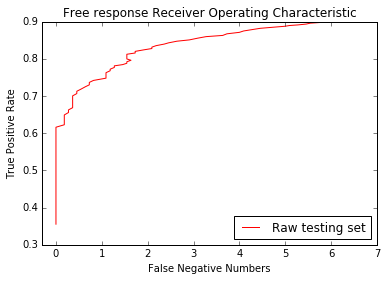

In [74]:
# size = 128

In [75]:
false_positive_rate, true_positive_rate, threshol = metrics.roc_curve(y_true.reshape(y_true.shape[0]*y_true.shape[1]), y_score.reshape(y_score.shape[0]*y_score.shape[1]))
thresholds = []
count = 1
for i in range(threshol.shape[0]):
    if(threshol[i] > 0.01 and count%100 == 0):
        thresholds.append(threshol[i])
    count += 1
thresholds = np.asarray(thresholds)

In [124]:
thresholds = []
for i in range(0,20,1):
    thresholds.append((i/np.float(20)))
thresholds = np.asarray(thresholds)

In [134]:
getPara(y_score[17], y_true[17], )

TypeError: getPara() takes exactly 3 arguments (2 given)

In [135]:
false_positive_rate, true_positive_rate, threshol = metrics.roc_curve(y_true.reshape(y_true.shape[0]*y_true.shape[1]), y_score.reshape(y_score.shape[0]*y_score.shape[1]))
thresholds = []
count = 1
for i in range(threshol.shape[0]):
    if(threshol[i] > 0.01 and count%100 == 0):
        thresholds.append(threshol[i])
    count += 1
thresholds = np.asarray(thresholds)

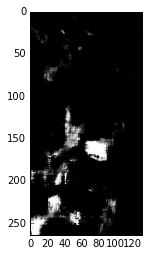

In [13]:
plt.imshow(y_score[18].reshape(264,132),'gray')

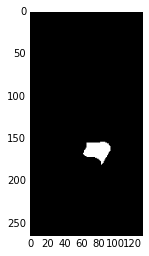

In [14]:
plt.imshow(y_true[18].reshape(264,132),'gray')

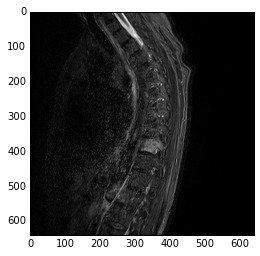

In [11]:
plt.imshow(SOURCE_IMAGE[18],'gray')

In [ ]:
model.predict_proba